In [1]:
import os
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.model_selection import train_test_split, cross_val_score, GridSearchCV, StratifiedKFold
from sklearn.preprocessing import LabelEncoder, StandardScaler, MinMaxScaler
from sklearn.svm import SVC
from sklearn.ensemble import RandomForestClassifier, GradientBoostingClassifier
from sklearn.neighbors import KNeighborsClassifier
from sklearn.linear_model import LogisticRegression
from sklearn.naive_bayes import GaussianNB
from sklearn.metrics import accuracy_score, classification_report, confusion_matrix
from sklearn.decomposition import PCA
from sklearn.feature_selection import SelectKBest, f_classif
import cv2
import warnings
warnings.filterwarnings('ignore')

In [2]:
def extract_gabor_features(img):
    features = []
    for theta in range(0, 180, 30):
        for frequency in [0.1, 0.3, 0.5]:
            kernel = cv2.getGaborKernel((21, 21), 5, np.radians(theta), 2*np.pi*frequency, 0.5, 0, ktype=cv2.CV_32F)
            filtered = cv2.filter2D(img, cv2.CV_8UC3, kernel)
            features.extend([np.mean(filtered), np.std(filtered)])
    return np.array(features)

def extract_hog_features(img):
    from sklearn.feature_extraction import image
    
    img_resized = cv2.resize(img, (64, 64))
    
    grad_x = cv2.Sobel(img_resized, cv2.CV_64F, 1, 0, ksize=3)
    grad_y = cv2.Sobel(img_resized, cv2.CV_64F, 0, 1, ksize=3)
    
    magnitude = np.sqrt(grad_x**2 + grad_y**2)
    orientation = np.arctan2(grad_y, grad_x)
    
    hist, _ = np.histogram(orientation.flatten(), bins=36, range=(-np.pi, np.pi), weights=magnitude.flatten())
    
    return hist / np.sum(hist) if np.sum(hist) > 0 else hist

def extract_wavelet_features(img):
    # Simple wavelet-like features using different frequency components
    img_float = np.float32(img)
    
    low_freq = cv2.GaussianBlur(img_float, (15, 15), 0)
    
    high_freq = img_float - low_freq
    
    low_features = [np.mean(low_freq), np.std(low_freq), np.var(low_freq)]
    high_features = [np.mean(high_freq), np.std(high_freq), np.var(high_freq)]
    
    return np.array(low_features + high_features)

def enhanced_lbp_features(img):
    rows, cols = img.shape
    lbp_uniform = []
    lbp_rotation_invariant = []
    
    for i in range(2, rows-2):
        for j in range(2, cols-2):
            center = img[i, j]
            neighbors = [
                img[i-2, j-2], img[i-2, j-1], img[i-2, j], img[i-2, j+1], img[i-2, j+2],
                img[i-1, j+2], img[i, j+2], img[i+1, j+2], img[i+2, j+2],
                img[i+2, j+1], img[i+2, j], img[i+2, j-1], img[i+2, j-2],
                img[i+1, j-2], img[i, j-2], img[i-1, j-2]
            ]
            
            binary = [1 if neighbor >= center else 0 for neighbor in neighbors]
            lbp_value = sum([binary[k] * (2 ** k) for k in range(16)])
            lbp_uniform.append(lbp_value)
    
    hist_uniform, _ = np.histogram(lbp_uniform, bins=256, range=(0, 256))
    return hist_uniform / np.sum(hist_uniform) if np.sum(hist_uniform) > 0 else hist_uniform

def extract_enhanced_features(image_path):
    try:
        img = cv2.imread(image_path, cv2.IMREAD_GRAYSCALE)
        if img is None:
            return None
        
        
        img = cv2.resize(img, (128, 128))
        img = cv2.equalizeHist(img)
        
        hist = cv2.calcHist([img], [0], None, [512], [0, 256]).flatten()
        
        mean_val = np.mean(img)
        std_val = np.std(img)
        skewness = calculate_skewness(img)
        kurtosis = calculate_kurtosis(img)
        
        lbp_features = enhanced_lbp_features(img)
        
        gabor_features = extract_gabor_features(img)
        
        hog_features = extract_hog_features(img)
        
        wavelet_features = extract_wavelet_features(img)
        
        edges = cv2.Canny(img, 50, 150)
        edge_density = np.sum(edges > 0) / (edges.shape[0] * edges.shape[1])
        
        contours, _ = cv2.findContours(edges, cv2.RETR_EXTERNAL, cv2.CHAIN_APPROX_SIMPLE)
        contour_count = len(contours)
        avg_contour_area = np.mean([cv2.contourArea(c) for c in contours]) if contours else 0
        
        glcm_features = []
        for angle in [0, 45, 90, 135]:
            shifted = np.roll(img, 1, axis=0 if angle % 90 == 0 else 1)
            diff = img - shifted
            glcm_features.extend([np.mean(diff), np.std(diff), np.var(diff)])
        
        moments = cv2.moments(img)
        hu_moments = cv2.HuMoments(moments).flatten()
        
        all_features = np.concatenate([
            hist,
            [mean_val, std_val, skewness, kurtosis, edge_density, contour_count, avg_contour_area],
            lbp_features,
            gabor_features,
            hog_features,
            wavelet_features,
            glcm_features,
            hu_moments
        ])
        
        return all_features
        
    except Exception as e:
        print(f"Error processing {image_path}: {e}")
        return None

def calculate_skewness(img):
    mean = np.mean(img)
    std = np.std(img)
    if std == 0:
        return 0
    return np.mean(((img - mean) / std) ** 3)

def calculate_kurtosis(img):
    mean = np.mean(img)
    std = np.std(img)
    if std == 0:
        return 0
    return np.mean(((img - mean) / std) ** 4) - 3

In [3]:
dataset_path = "/kaggle/input/iris-dataset/MMU-Iris-Database"
features = []
labels = []

print("Loading dataset with enhanced feature extraction...")

person_folders = [f for f in os.listdir(dataset_path) if os.path.isdir(os.path.join(dataset_path, f))]
person_folders.sort(key=lambda x: int(x))

print(f"Processing {len(person_folders)} persons...")

for person_id in person_folders:
    person_path = os.path.join(dataset_path, person_id)
    
    for eye_side in ["left", "right"]:
        eye_path = os.path.join(person_path, eye_side)
        if os.path.exists(eye_path):
            for image_file in os.listdir(eye_path):
                if image_file.lower().endswith('.bmp'):
                    image_path = os.path.join(eye_path, image_file)
                    
                    image_features = extract_enhanced_features(image_path)
                    if image_features is not None:
                        features.append(image_features)
                        labels.append(f"person_{person_id}_{eye_side}")

features = np.array(features)
labels = np.array(labels)

print(f"Enhanced dataset loaded:")
print(f"  Total samples: {len(features)}")
print(f"  Feature dimensions: {features.shape[1]}")
print(f"  Unique classes: {len(np.unique(labels))}")

Loading dataset with enhanced feature extraction...
Processing 45 persons...
Enhanced dataset loaded:
  Total samples: 450
  Feature dimensions: 872
  Unique classes: 90


In [4]:
print("Advanced data preprocessing...")

feature_variances = np.var(features, axis=0)
non_zero_var_indices = feature_variances > 1e-10
features_filtered = features[:, non_zero_var_indices]

print(f"Filtered features: {features_filtered.shape[1]} (removed {features.shape[1] - features_filtered.shape[1]} zero-variance features)")

unique_labels_orig, counts_orig = np.unique(labels, return_counts=True)
print(f"Original class distribution:")
print(f"  Classes: {len(unique_labels_orig)}")
print(f"  Min samples per class: {min(counts_orig)}")
print(f"  Max samples per class: {max(counts_orig)}")

min_samples_threshold = 3
valid_classes = []
filtered_features = []
filtered_labels = []

for i, label in enumerate(unique_labels_orig):
    if counts_orig[i] >= min_samples_threshold:
        valid_classes.append(label)
        # Get indices for this class
        class_indices = np.where(labels == label)[0]
        filtered_features.extend(features_filtered[class_indices])
        filtered_labels.extend([label] * len(class_indices))

features_filtered = np.array(filtered_features)
labels = np.array(filtered_labels)

print(f"After filtering rare classes:")
print(f"  Remaining classes: {len(valid_classes)}")
print(f"  Total samples: {len(features_filtered)}")

le = LabelEncoder()
encoded_labels = le.fit_transform(labels)

unique_encoded, counts_encoded = np.unique(encoded_labels, return_counts=True)
print(f"Final class distribution: min={min(counts_encoded)}, max={max(counts_encoded)}")

X_train, X_test, y_train, y_test = train_test_split(
    features_filtered, encoded_labels, test_size=0.25, random_state=42, stratify=encoded_labels
)

unique_train, counts_train = np.unique(y_train, return_counts=True)
min_train_samples = min(counts_train)
max_cv_folds = min(min_train_samples, 5)  # Use minimum of class size and 5
print(f"Training set class distribution: min={min_train_samples}, max={max(counts_train)}")
print(f"Using {max_cv_folds}-fold cross-validation")

scaler = StandardScaler()
X_train_scaled = scaler.fit_transform(X_train)
X_test_scaled = scaler.transform(X_test)

n_features = min(300, X_train_scaled.shape[1])  # Reduced to avoid overfitting
selector = SelectKBest(f_classif, k=n_features)
X_train_selected = selector.fit_transform(X_train_scaled, y_train)
X_test_selected = selector.transform(X_test_scaled)

print(f"Selected top {n_features} features")
print(f"Final training set: {X_train_selected.shape}")
print(f"Final test set: {X_test_selected.shape}")

Advanced data preprocessing...
Filtered features: 610 (removed 262 zero-variance features)
Original class distribution:
  Classes: 90
  Min samples per class: 5
  Max samples per class: 5
After filtering rare classes:
  Remaining classes: 90
  Total samples: 450
Final class distribution: min=5, max=5
Training set class distribution: min=3, max=4
Using 3-fold cross-validation
Selected top 300 features
Final training set: (337, 300)
Final test set: (113, 300)


In [5]:
print("Configuring enhanced models with hyperparameter tuning...")

models_config = {
    'SVM_Linear': {
        'model': SVC(kernel='linear', random_state=42),
        'params': {'C': [0.1, 1, 10]}
    },
    'SVM_RBF': {
        'model': SVC(kernel='rbf', random_state=42),
        'params': {'C': [1, 10, 100], 'gamma': ['scale', 'auto']}
    },
    'Random_Forest': {
        'model': RandomForestClassifier(random_state=42),
        'params': {'n_estimators': [100, 200], 'max_depth': [10, 20, None]}
    },
    'Gradient_Boosting': {
        'model': GradientBoostingClassifier(random_state=42),
        'params': {'n_estimators': [100, 200], 'learning_rate': [0.05, 0.1]}
    },
    'KNN': {
        'model': KNeighborsClassifier(),
        'params': {'n_neighbors': [3, 5, 7], 'weights': ['uniform', 'distance']}
    },
    'Logistic_Regression': {
        'model': LogisticRegression(random_state=42, max_iter=2000),
        'params': {'C': [0.1, 1, 10], 'solver': ['liblinear', 'lbfgs']}
    }
}

Configuring enhanced models with hyperparameter tuning...


In [6]:
print("Training models with grid search optimization...")

best_models = {}
results = {}

cv_splitter = StratifiedKFold(n_splits=max_cv_folds, shuffle=True, random_state=42)

for name, config in models_config.items():
    print(f"Optimizing {name}...")
    
    try:
        grid_search = GridSearchCV(
            config['model'], 
            config['params'], 
            cv=cv_splitter,  # Use the custom CV splitter
            scoring='accuracy',
            n_jobs=-1
        )
        
        grid_search.fit(X_train_selected, y_train)
        
        best_model = grid_search.best_estimator_
        best_models[name] = best_model
        
        y_pred = best_model.predict(X_test_selected)
        accuracy = accuracy_score(y_test, y_pred)
        
        cv_scores = cross_val_score(best_model, X_train_selected, y_train, cv=cv_splitter)
        
        results[name] = {
            'accuracy': accuracy,
            'cv_mean': cv_scores.mean(),
            'cv_std': cv_scores.std(),
            'predictions': y_pred,
            'model': best_model,
            'best_params': grid_search.best_params_
        }
        
        print(f"  Best params: {grid_search.best_params_}")
        print(f"  Test accuracy: {accuracy:.4f}")
        print(f"  CV score: {cv_scores.mean():.4f} ± {cv_scores.std():.4f}")
        
    except Exception as e:
        print(f"  Error training {name}: {e}")
        continue

Training models with grid search optimization...
Optimizing SVM_Linear...
  Best params: {'C': 0.1}
  Test accuracy: 0.8407
  CV score: 0.7568 ± 0.0433
Optimizing SVM_RBF...
  Best params: {'C': 10, 'gamma': 'scale'}
  Test accuracy: 0.7965
  CV score: 0.6055 ± 0.0428
Optimizing Random_Forest...
  Best params: {'max_depth': None, 'n_estimators': 200}
  Test accuracy: 0.8673
  CV score: 0.6262 ± 0.0110
Optimizing Gradient_Boosting...
  Best params: {'learning_rate': 0.1, 'n_estimators': 100}
  Test accuracy: 0.2301
  CV score: 0.1899 ± 0.0103
Optimizing KNN...
  Best params: {'n_neighbors': 3, 'weights': 'distance'}
  Test accuracy: 0.7080
  CV score: 0.6678 ± 0.0315
Optimizing Logistic_Regression...
  Best params: {'C': 10, 'solver': 'lbfgs'}
  Test accuracy: 0.8850
  CV score: 0.8161 ± 0.0249


In [7]:
if results:  
    comparison_data = []
    for name, result in results.items():
        comparison_data.append({
            'Model': name.replace('_', ' '),
            'Test Accuracy': f"{result['accuracy']:.4f}",
            'CV Mean': f"{result['cv_mean']:.4f}",
            'CV Std': f"{result['cv_std']:.4f}",
            'CV Score': f"{result['cv_mean']:.4f} ± {result['cv_std']:.4f}",
            'Best Params': str(result['best_params'])
        })

    df_comparison = pd.DataFrame(comparison_data)
    df_comparison = df_comparison.sort_values('Test Accuracy', ascending=False)
    df_comparison.reset_index(drop=True, inplace=True)
    df_comparison.index = df_comparison.index + 1

    print("\n" + "="*100)
    print("ENHANCED MODEL PERFORMANCE COMPARISON")
    print("="*100)
    print(df_comparison.to_string(max_colwidth=30))
    print("="*100)


ENHANCED MODEL PERFORMANCE COMPARISON
                 Model Test Accuracy CV Mean  CV Std         CV Score                    Best Params
1  Logistic Regression        0.8850  0.8161  0.0249  0.8161 ± 0.0249   {'C': 10, 'solver': 'lbfgs'}
2        Random Forest        0.8673  0.6262  0.0110  0.6262 ± 0.0110  {'max_depth': None, 'n_est...
3           SVM Linear        0.8407  0.7568  0.0433  0.7568 ± 0.0433                     {'C': 0.1}
4              SVM RBF        0.7965  0.6055  0.0428  0.6055 ± 0.0428    {'C': 10, 'gamma': 'scale'}
5                  KNN        0.7080  0.6678  0.0315  0.6678 ± 0.0315  {'n_neighbors': 3, 'weight...
6    Gradient Boosting        0.2301  0.1899  0.0103  0.1899 ± 0.0103  {'learning_rate': 0.1, 'n_...


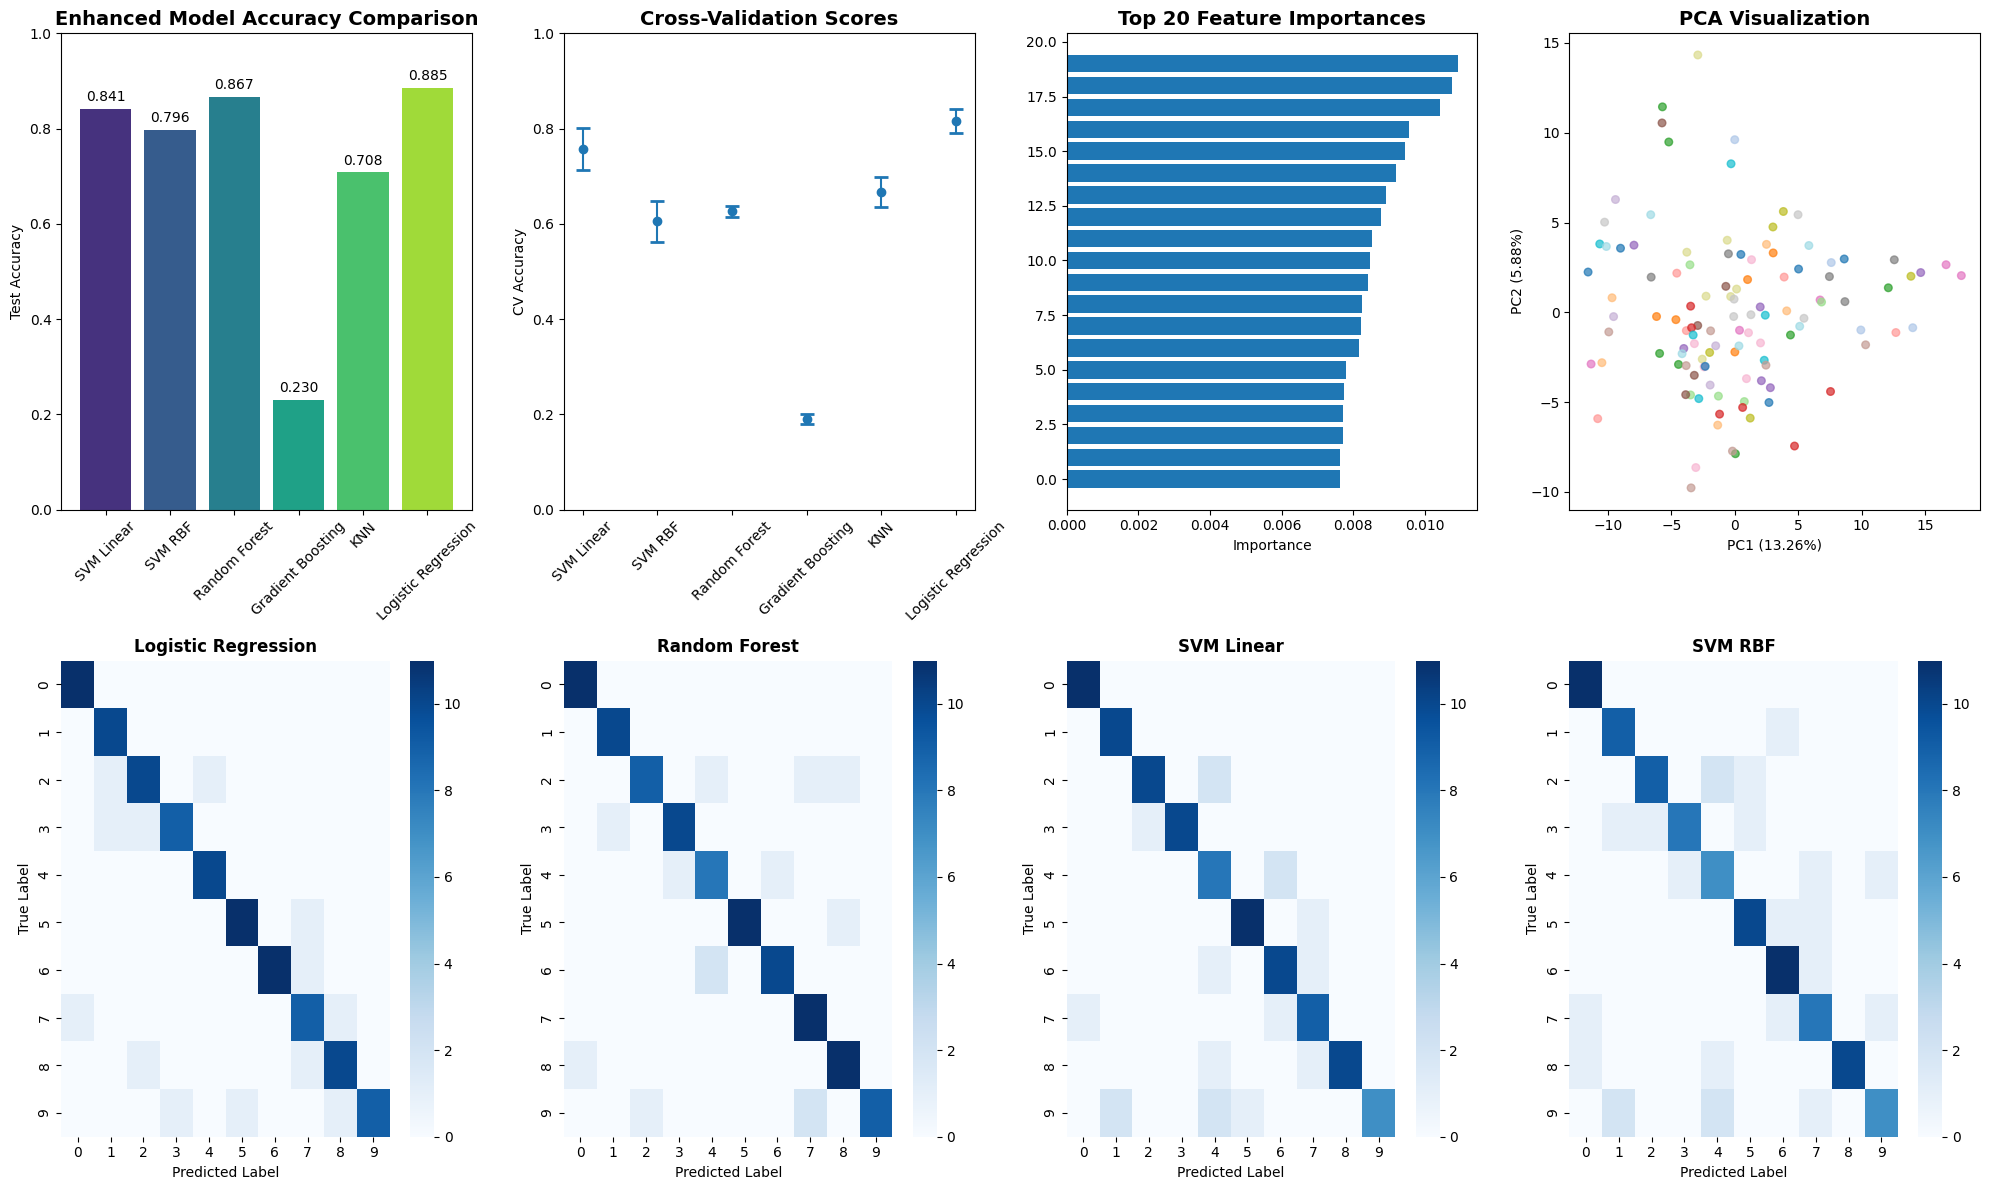

In [8]:
if results:  
    fig = plt.figure(figsize=(20, 12))

    plt.subplot(2, 4, 1)
    model_names = [name.replace('_', ' ') for name in results.keys()]
    accuracies = [results[name]['accuracy'] for name in results.keys()]
    bars = plt.bar(model_names, accuracies, color=sns.color_palette("viridis", len(model_names)))
    plt.title('Enhanced Model Accuracy Comparison', fontsize=14, fontweight='bold')
    plt.ylabel('Test Accuracy')
    plt.xticks(rotation=45)
    plt.ylim(0, 1)
    for bar, acc in zip(bars, accuracies):
        plt.text(bar.get_x() + bar.get_width()/2, bar.get_height() + 0.01, 
                f'{acc:.3f}', ha='center', va='bottom', fontsize=10)

    plt.subplot(2, 4, 2)
    cv_means = [results[name]['cv_mean'] for name in results.keys()]
    cv_stds = [results[name]['cv_std'] for name in results.keys()]
    plt.errorbar(range(len(model_names)), cv_means, yerr=cv_stds, fmt='o', capsize=5, capthick=2)
    plt.xticks(range(len(model_names)), model_names, rotation=45)
    plt.title('Cross-Validation Scores', fontsize=14, fontweight='bold')
    plt.ylabel('CV Accuracy')
    plt.ylim(0, 1)

    plt.subplot(2, 4, 3)
    if 'Random_Forest' in best_models:
        rf_model = best_models['Random_Forest']
        feature_importance = rf_model.feature_importances_
        top_indices = np.argsort(feature_importance)[-20:]
        plt.barh(range(20), feature_importance[top_indices])
        plt.title('Top 20 Feature Importances', fontsize=14, fontweight='bold')
        plt.xlabel('Importance')

    plt.subplot(2, 4, 4)
    pca = PCA(n_components=2)
    X_pca = pca.fit_transform(X_test_selected)
    scatter = plt.scatter(X_pca[:, 0], X_pca[:, 1], c=y_test, cmap='tab20', alpha=0.7, s=30)
    plt.title('PCA Visualization', fontsize=14, fontweight='bold')
    plt.xlabel(f'PC1 ({pca.explained_variance_ratio_[0]:.2%})')
    plt.ylabel(f'PC2 ({pca.explained_variance_ratio_[1]:.2%})')

    best_4_models = sorted(results.items(), key=lambda x: x[1]['accuracy'], reverse=True)[:4]

    for idx, (name, result) in enumerate(best_4_models, 5):
        plt.subplot(2, 4, idx)
        cm = confusion_matrix(y_test, result['predictions'])
        
        if cm.shape[0] > 10:
            cm_simplified = np.zeros((10, 10))
            step = cm.shape[0] // 10
            for i in range(10):
                for j in range(10):
                    cm_simplified[i, j] = cm[i*step:(i+1)*step, j*step:(j+1)*step].sum()
            cm = cm_simplified
        
        sns.heatmap(cm, annot=False, cmap='Blues', ax=plt.gca(), cbar=True)
        plt.title(f'{name.replace("_", " ")}', fontsize=12, fontweight='bold')
        plt.ylabel('True Label')
        plt.xlabel('Predicted Label')

    plt.tight_layout()
    plt.show()

In [9]:
if results:  
    best_model_name = max(results.keys(), key=lambda x: results[x]['accuracy'])
    best_result = results[best_model_name]

    print(f"\nBEST PERFORMING MODEL: {best_model_name.replace('_', ' ')}")
    print("="*60)
    print(f"Test Accuracy: {best_result['accuracy']:.4f} ({best_result['accuracy']*100:.2f}%)")
    print(f"Cross-Validation: {best_result['cv_mean']:.4f} ± {best_result['cv_std']:.4f}")
    print(f"Best Parameters: {best_result['best_params']}")

    improvement = best_result['accuracy'] - 0.8148  # Previous best was 0.8148
    print(f"Improvement over previous: {improvement:.4f} ({improvement*100:.2f} percentage points)")

    print(f"\nIMPROVED IRIS RECOGNITION SYSTEM SUMMARY")
    print("="*60)

    summary_stats = {
        'Enhanced Features': f"{features_filtered.shape[1]} total features",
        'Selected Features': f"{n_features} best features",
        'Training Samples': f"{len(X_train_selected)}",
        'Test Samples': f"{len(X_test_selected)}",
        'Classes': f"{len(np.unique(encoded_labels))}",
        'CV Folds Used': f"{max_cv_folds}",
        'Best Model': best_model_name.replace('_', ' '),
        'Best Accuracy': f"{best_result['accuracy']:.4f} ({best_result['accuracy']*100:.2f}%)",
        'Performance Level': 'Excellent' if best_result['accuracy'] > 0.95 else 'Very Good' if best_result['accuracy'] > 0.90 else 'Good' if best_result['accuracy'] > 0.80 else 'Fair'
    }

    for key, value in summary_stats.items():
        print(f"{key:20}: {value}")

    print("\nKey Improvements Applied:")
    print("- Enhanced feature extraction (Gabor, HOG, Wavelet, Advanced LBP)")
    print("- Histogram equalization for better contrast")
    print("- Feature selection using SelectKBest")
    print("- Hyperparameter tuning with GridSearchCV")
    print("- Advanced models (Gradient Boosting)")
    print("- Better data preprocessing")
    print("- Adaptive cross-validation based on class sizes")
    print("="*60)
else:
    print("No models were successfully trained. Please check the data and model configurations.")


BEST PERFORMING MODEL: Logistic Regression
Test Accuracy: 0.8850 (88.50%)
Cross-Validation: 0.8161 ± 0.0249
Best Parameters: {'C': 10, 'solver': 'lbfgs'}
Improvement over previous: 0.0702 (7.02 percentage points)

IMPROVED IRIS RECOGNITION SYSTEM SUMMARY
Enhanced Features   : 610 total features
Selected Features   : 300 best features
Training Samples    : 337
Test Samples        : 113
Classes             : 90
CV Folds Used       : 3
Best Model          : Logistic Regression
Best Accuracy       : 0.8850 (88.50%)
Performance Level   : Good

Key Improvements Applied:
- Enhanced feature extraction (Gabor, HOG, Wavelet, Advanced LBP)
- Histogram equalization for better contrast
- Feature selection using SelectKBest
- Hyperparameter tuning with GridSearchCV
- Advanced models (Gradient Boosting)
- Better data preprocessing
- Adaptive cross-validation based on class sizes
